# Covid-19 Model
This model aims to estimate the R0 values necessary to limit the spread of the virus such that hospitals are not overwhelmed. 

It also aims to evaluate certain proposals and their corresponding expected R0 values against the outcomes of such policies. Examples include opening the economy up again, opening the economy with the exception of the elderly who will have mandated quarantine indefinitely, and continuing with self-isolation in its current degree (schools, restaruant, and other non-essential services closed). 

This model specifies a number of parameters and takes in the R0 values printing out the number of cases, deaths and costs as the virus progesses through the population. 

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

[[0.000000e+00 2.100000e+02 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00]
 [5.000000e+00 7.240000e+02 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00]
 [1.000000e+01 2.043000e+03 0.000000e+00 2.250000e+01 0.000000e+00
  1.500000e+01 7.500000e+00]
 [1.500000e+01 5.432000e+03 0.000000e+00 6.415000e+01 2.250000e+01
  3.565000e+01 6.000000e+00]
 [2.000000e+01 1.414600e+04 0.000000e+00 1.672000e+02 6.415000e+01
  9.030000e+01 1.275000e+01]
 [2.500000e+01 3.561300e+04 9.000000e+00 4.056000e+02 1.447000e+02
  2.324000e+02 2.850000e+01]
 [3.000000e+01 8.344600e+04 2.401750e+01 1.040600e+03 3.639500e+02
  5.956500e+02 8.100000e+01]
 [3.500000e+01 1.585040e+05 6.052750e+01 2.583350e+03 9.375500e+02
  1.474050e+03 1.717500e+02]
 [4.000000e+01 2.223630e+05 1.523325e+02 6.047850e+03 2.322450e+03
  3.303900e+03 4.215000e+02]
 [4.500000e+01 2.500410e+05 3.913500e+02 1.146085e+04 5.371200e+03
  5.138650e+03 9.510000e+02]]
the maximium number of beds needed at o

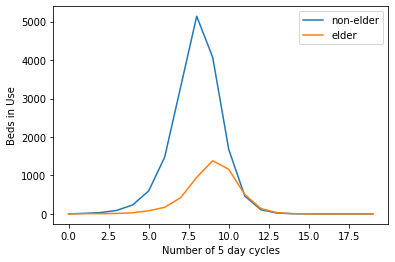

In [257]:

#Parameters
pop = [100000,100000,100000]  #young,mid,old population
epid_figs = [5,5,10] #inc_period,contagion_period, symptomatic_period
hosp_rate = [0.05,0.10,0.75] #hospitalization rate for young,mid,elder
icu_rate = [0.1,0.25,0.50] #critical care rate for young,mid,elder once in hospital 
death_rate = [0.25,.4,0.5] #death rate for young,mid,elder in critical care
death_rate_upd = [0.50,0.60,0.75] #death rate for young,mid,elder if not in critical care (i.e ICU is full)
hosp_capacity = [1000,100]  #[beds,vent]
hosp_time = [5,10]  #[avg bed time,avg vent time]
costs = [1,1,1] #[cost_per_in_hosp,cost_per_death,cost_per_self_isolate_day] 

parameters = [pop,epid_figs,hosp_rate,crit_care_rate,death_rate,death_rate_upd,hosp_capacity,hosp_time,costs]

young = [2,1,0.01]
mid = [1,1,0.05]
old = [0.01,0.05,0.001]
init_R = np.asarray([young,mid,old])
Initial_Infected = [100,100,10]

time_v_figures = covid_model_1(init_R,parameters,Initial_Infected)

#how to plot with time on bottom
cases_over_time = [arr[1] for arr in time_v_figures] 
beds_over_time_1 = [arr[5] for arr in time_v_figures]
beds_over_time_2 = [arr[6] for arr in time_v_figures]


# plt.plot(cases_over_time[1:])
# plt.xlabel("Number of 5 day cycles")
# plt.ylabel("Total Cases")

plt.plot(beds_over_time_1[1:],label = 'non-elder')
plt.xlabel("Number of 5 day cycles")
plt.ylabel("Beds in Use")

plt.plot(beds_over_time_2[1:],label = 'elder')
plt.xlabel("Number of 5 day cycles")
plt.ylabel("Beds in Use")

plt.legend()


print(time_v_figures[:10])

p = time_v_figures[:,3].max()
print("the maximium number of beds incl. ICU needed at one time was: ", p)
print("meaning that this percentage of the pop was in the hospital, ", (p/sum(pop))*100)



In [256]:
#Model Building

#R is a 3x3 matrix that represents the people the virus is expected to transmit to through a contagious person 
def covid_model_1(init_R,Param,Initial_Infected):
    
    #define param
    pop = Param[0]
    inc_period,contagion_period, symptomatic_period = Param[1][0],Param[1][1],Param[1][2]
    hosp_rate = Param[2]
    icu_rate = Param[3] #critical care rate for young,mid,elder once in hospital 
    death_rate = Param[4] #death rate for young,mid,elder in critical care
    death_rate_upd = Param[5] #death rate for young,mid,elder if not in critical care (i.e ICU is full)
    hosp_capacity = Param[6]  #[beds,vent]
    hosp_time = Param[7]  #[avg bed time,avg vent time]
    costs = Param[8] #[cost_per_in_hosp,cost_per_death,cost_per_self_isolate_day] 
    
    R = init_R
    
    un_infected = np.subtract(pop,Initial_Infected)
    just_infected = Initial_Infected
    newly_symptomatic = [0,0,0]
    oldly_symptomatic = [0,0,0]
    hospitalized = [0,0,0]
    intensive_care_new = [0,0,0]
    intensive_care_old = [0,0,0]
    dead = [0,0,0]
    released = [0,0,0]
    
    
    total_cases = sum(Initial_Infected)
    deaths = 0
    beds_occ = 0
    vents_occ = 0
    
    
    t = 0
    
    time_v_figures = [0,total_cases,deaths,0,0,0,0]
    
    
    
    while(t<100 and total_cases <= (sum(pop)*.9)):
        t = t + inc_period 
        
        #the newly symptomatic people pass it on --> calculate new_cases
        oldly_symptomatic = newly_symptomatic
        newly_symptomatic = just_infected
        just_infected = new_cases(R,newly_symptomatic,un_infected,sum(pop)) #returns newly infected people
        
        #updates
        un_infected = np.subtract(un_infected,just_infected) 
        total_cases = total_cases + sum(just_infected) 
        
        
        #the ICU people stay for 10 days on average before being released or dying 

        #the old intensive care patients either get released or die :(
        dead,released = icu_outcome(intensive_care_old,death_rate,dead,released)
        vents_occ = vents_occ - sum(intensive_care_old) 
        beds_occ = beds_occ - sum(intensive_care_old)

        intensive_care_old = intensive_care_new #new icu patients become old ones
        
        #the old hosp people either get released or go to ICU 
        intensive_care_new,released,beds_occ = new_icu(hospitalized,icu_rate,released,beds_occ)
        vents_occ = vents_occ + sum(intensive_care_new)
        
        #the oldly symptomatic people get hospitalized or get better 
        hospitalized,released,beds_occ = new_hospitalized(oldly_symptomatic,hosp_rate,released,beds_occ) 
        
        deaths = sum(dead)
        
        #track
        time_v_figures = np.vstack((time_v_figures,[t,total_cases,deaths,beds_occ,vents_occ,hospitalized[0]+hospitalized[1],hospitalized[2]]))

    return (time_v_figures)
    
    

In [191]:
#Helper Functions

#Takes the probabilities, the number of newly_symptomatic people, 
# uninfected people and the total population and returns the number of newly infected people and the updated R
def new_cases(R,newly_symptomatic,un_infected,total_pop): 
    just_infected = [0,0,0]
    
    for i in range(3): #for each age range
        
        
        for j in range(newly_symptomatic[i]): #for each symptomatic person in that age range
            #used to scale the R 
            prop_un_infect = sum(un_infected)/total_pop
            
            #update just_infected
            newly_infected = infect_new(prop_un_infect,R[i])
            just_infected = np.add(just_infected,newly_infected)
            
            #update un_infected 
            un_infected = np.subtract(un_infected,newly_infected) #over updates since subtracts three times
         
         
    return just_infected
    
def infect_new(p,R): #p is here to scale the R so that when most of the pop has had it, the chance is low
    
    return [normal_dist(p*R[0]),normal_dist(p*R[1]),normal_dist(p*R[2])]
    
def normal_dist(u): 
    if(u == 0):
        return 0
    
    if(u<1):
        x = np.random.normal(u,0.25)
    else:
        x = np.random.normal(u,.4)
    #this is questionable - too low a value and 
    #low probabilities never come true, too high and its biased towards higher due to rounding + >=0
    
    if(x>0):
        return round(x)
    else:
        return 0 


#LATER, WE CAN FIX THIS SUCH THAT EITHER A WHOLE PERSON DIES OR LIVES but no decimals

#the old intensive care patients either get released or die :(
#Returns dead,released
def icu_outcome(icu,d_r,dead,released):
    
    dead = np.add(dead,np.multiply(icu,d_r))
    released = np.add(released, np.subtract(icu,np.multiply(icu,d_r))) 
    
    return dead,released
    
    
#the old hosp people either get released or go to ICU 
def new_icu(hosp,icu_rate,released,beds_occ):
    
    new_icu_patients = np.multiply(hosp,icu_rate) 
    new_releases = np.subtract(hosp,new_icu_patients)
    released = np.add(released,new_releases)
    
    beds_occ = beds_occ - sum(new_releases)
    
    return new_icu_patients,released,beds_occ
    
    
#the oldly symptomatic people get hospitalized or get better     
def new_hospitalized(symptomatic,hosp_rate,released,beds_occ):
    
    new_patients = np.multiply(symptomatic,hosp_rate)  
    released = np.add(released,np.subtract(symptomatic,new_patients))
    
    beds_occ = beds_occ + sum(new_patients) 
    
    return new_patients,released,beds_occ



In [146]:
#Tests for Helper Functions

#Takes the probabilities, the number of newly_symptomatic people, 
# uninfected people and the total population and returns the number of newly infected people and the updated R
def test_new_cases(R):
    newly_symptomatic = [30,30,30]
    uninfected = [700,700,700]
    total_pop = sum(uninfected)
    
    newly_infected = new_cases(R,newly_symptomatic,uninfected,total_pop)

    #print("Newly infected:", newly_infected)
    
    return newly_infected 
    

In [155]:
#Test Number 1 - Generating new numbers of cases
total = [0,0,0]

young = [1,1,1]
mid = [1,1,1]
old = [1,1,1]
R_1 = np.asarray([young,mid,old])
    
for i in range(100):
    newly_infected = test_new_cases(R_1)
    total = np.add(total,newly_infected)

print("Total:",total)
print("Average:",total/100) #sanity check - about equal to 3x the number of infected minus discounting

total = [0,0,0]

young = [2,1,0]
mid = [2,1,0]
old = [2,1,0]
R_2 = np.asarray([young,mid,old])
    
for i in range(100):
    newly_infected = test_new_cases(R_2)
    total = np.add(total,newly_infected)

print("Total:",total)
print("Average:",total/100) #sanity check - should be no old people who have it 




Total: [8725 8740 8739]
Average: [87.25 87.4  87.39]
Total: [17002  8747     0]
Average: [170.02  87.47   0.  ]


In [183]:
#Test 2 - ICU Patients dying or getting released
#the old intensive care patients either get released or die :(
#Returns dead,released
#def icu_outcome(icu,d_r,dead,released):

#FOR NOW, WE WILL ASSUME IT DOESN"T MATTER THAT A DECIMAL PLACE PERSON IS DEAD 
 
dead = [0,0,0]
d_r = [.1,.25,.5]
icu = [10,10,10]
released = [0,0,0]

dead,released = icu_outcome(icu,d_r,dead,released)
print(released)
print(dead)
    

[9.  7.5 5. ]
[1.  2.5 5. ]


In [195]:
#Test 3 - Hospital Patients getting released or sent to the icu 

#the old hosp people either get released or go to ICU 
#def new_icu(hosp,icu_rate,released,beds_occ):
#returns new_icu_patients,released,beds_occ

hosp = [10,10,10]
icu_rate = [0.1,0.25,0.5]
released = [5,5,5]
beds_occ = 35

new_p,released,beds_occ = new_icu(hosp,icu_rate,released,beds_occ)

print(new_p)
print(released)
print(beds_occ) #

[1.  2.5 5. ]
[14.  12.5 10. ]
13.5


In [197]:
#Test 4 - Symptomatic People going to the hospital 
#the oldly symptomatic people get hospitalized or get better     
#def new_hospitalized(symptomatic,hosp_rate,released,beds_occ):
#returns new patients, released,beds_occ

sympt = [10,10,10]
hosp_rate = [0.1,0.25,0.75]
released = [0,0,0]
beds_occ = 5

new_p,released,beds_occ = new_hospitalized(sympt,hosp_rate,released,beds_occ)

print(new_p)
print(np.add(new_p,released))
print(beds_occ)


[1.  2.5 7.5]
[10. 10. 15.]
16.0
